# Train YOLO26 Object Detection Model on a Custom Dataset

<a target="_blank" href="https://github.com/ultralytics/ultralytics">
  <img src="https://img.shields.io/badge/Ultralytics-YOLO26-blue" alt="Ultralytics">
</a>

YOLO26 features a unified architecture that supports detection, segmentation, and pose tasks within a single model family. In this notebook, we fine-tune a YOLO26m checkpoint on a custom boxing-punch detection dataset from [Roboflow Universe](https://universe.roboflow.com/) and evaluate the results.

| Tool | Purpose |
|---|---|
| [Ultralytics](https://docs.ultralytics.com/) | YOLO26 training, validation, and inference |
| [Roboflow](https://roboflow.com/) | Dataset hosting and download |
| [Comet ML](https://www.comet.com/) | Experiment tracking and logging |
| [Supervision](https://supervision.roboflow.com/) | Detection visualization |

---

## Outline

1. **Setup** --- Environment and API keys (Roboflow, Comet), working directory
2. **Inference with pre-trained model** --- Run YOLO26m on a sample image; inspect detections and visualize with Supervision
3. **Fine-tune on custom dataset** --- Download a Roboflow dataset in YOLO26 format
4. **Model training** --- Train with Ultralytics, log to Comet; inspect training outputs (confusion matrix, curves, sample predictions)
5. **Validate fine-tuned model** --- Run validation on the best checkpoint
6. **Inference with fine-tuned model** --- Predict on test images; visualize a grid of annotated samples

## Setup

Install dependencies, configure API keys, and set the working directory used for datasets and model outputs.

### Configure API keys

To fine-tune YOLO26, you need to provide your Roboflow API key. Follow these steps:

- Store Roboflow API Key under the name `ROBOFLOW_API_KEY` in `.env` file.
- Store Comet API Key under the name `api_key` in `.comet.config` file.

### Working directory

To simplify the management of datasets, images, and models, create a constant `HOME` pointing to the current working directory.

In [1]:
import os

# Root directory for datasets, runs, and sample images
HOME = os.getcwd()
print(HOME)

/teamspace/studios/this_studio


In [ ]:
import ultralytics

# Verify Ultralytics install and environment (CUDA, dependencies)
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA L4, 22813MiB)
Setup complete ✅ (8 CPUs, 31.3 GB RAM, 41.8/368.0 GB disk)


## Inference with pre-trained model

Run detection using the pre-trained YOLO26m checkpoint on a sample image. We also inspect detection outputs and visualize them with Supervision.

Perform the same detection programmatically using the Ultralytics Python API. This gives direct access to bounding boxes, confidence scores, and class IDs.

In [3]:
from ultralytics import YOLO
from PIL import Image

# Load the pre-trained model
model = YOLO('yolo26m.pt')
image = Image.open(f'{HOME}/boxing.png')

# Perform inference
result = model.predict(image, verbose=False)[0]

The obtained `result` object contains information about the location, classes, and confidence levels of the detected objects.

In [ ]:
# Bounding box coordinates in (x_min, y_min, x_max, y_max) format
result.boxes.xyxy

tensor([[193.1463,  46.6237, 568.3085, 394.2909]], device='cuda:0')

In [5]:
# Confidence score for each detection
result.boxes.conf

tensor([0.9319], device='cuda:0')

In [6]:
# Class ID for each detection (maps to COCO category indices)
result.boxes.cls

tensor([0.], device='cuda:0')

### Visualize detections

Convert the Ultralytics result to a Supervision `Detections` object, then draw bounding boxes and labels on the image using a helper function.

In [7]:
import supervision as sv

# Convert Ultralytics result to Supervision Detections
detections = sv.Detections.from_ultralytics(result)

In [8]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    """Annotate an image with detections."""
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    # Create annotators
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    # Annotate and return
    out = image.copy()
    out = box_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

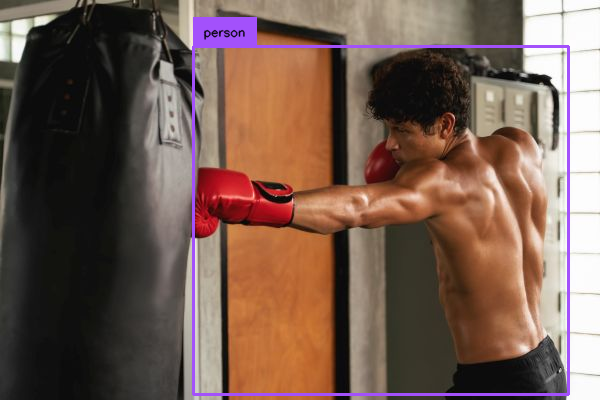

In [ ]:
# Draw boxes and labels on the sample image
annotated_image = annotate(image, detections)
annotated_image

## Fine-tune YOLO26 on custom dataset

Download a labeled dataset from Roboflow Universe in YOLO26-compatible format. We will use one of the [datasets](https://universe.roboflow.com/markmcquade/boxpunch-detector) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolo26` export format.

In [10]:
# Create a directory to store the downloaded dataset
!mkdir {HOME}/datasets
%cd {HOME}/datasets

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

from roboflow import Roboflow

# Authenticate with Roboflow and download the dataset in YOLO26 format
ROBOFLOW_API_KEY = os.environ.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("markmcquade").project("boxpunch-detector")
version = project.version(19)
dataset = version.download("yolo26")

/teamspace/studios/this_studio/datasets


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Boxpunch-Detector--19 in yolo26:: 100%|██████████| 1500/1500 [00:00<00:00, 6052.03it/s]


## Model Training

Launch YOLO26m fine-tuning. Training metrics are automatically logged to [Comet ML](https://www.comet.com/) for experiment tracking. Key parameters:

| Arguments | Value | Description |
|---|---|---|
| `model` | `yolo26m.pt` | Pre-trained checkpoint to start from |
| `epochs` | `20` | Number of training epochs |
| `imgsz` | `640` | Input image resolution |
| `plots` | `True` | Save training plots (confusion matrix, curves) |

In [11]:
import comet_ml

# Authenticate with Comet for experiment tracking
comet_ml.login(project_name="yolo26-object-detection")

In [12]:
%cd {HOME}

from ultralytics import YOLO

# Load the pre-trained model
model = YOLO('yolo26m.pt')

# Fine-tune YOLO26m on the downloaded dataset for 20 epochs
model.train(
    data=f'{dataset.location}/data.yaml',
    project='yolo26-object-detection',
    epochs=20,
    imgsz=640,
    plots=True
)

using dhist requires you to install the `pickleshare` library.


/teamspace/studios/this_studio
Ultralytics 8.4.14 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA L4, 22813MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/teamspace/studios/this_studio/datasets/Boxpunch-Detector--19/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, opt

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sitamgithub-msit/yolo26-object-detection/6d3ca2844d014470826d1b93572f0520



Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


COMET INFO: Couldn't find a Git repository in '/teamspace/studios/this_studio' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5, 3, True]        
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512,

       1/20      9.16G      1.324      5.239    0.02068         45        640: 100% ━━━━━━━━━━━━ 42/42 1.5it/s 28.3s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 2.7s/it 5.4s9.3s
                   all         47         84      0.622      0.272      0.256      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/20      10.8G      1.342      2.569    0.02102         53        640: 100% ━━━━━━━━━━━━ 42/42 2.4it/s 17.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.0it/s 0.5s1.1s
                   all         47         84      0.339      0.634       0.44      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/20      10.9G      1.404      1.943    0.02184         61        640: 100% ━━━━━━━━━━━━ 42/42 2.4it/s 17.2s0.4s
                 Class     Images  Instanc

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : influential_bulb_7295
COMET INFO:     url                   : https://www.comet.com/sitamgithub-msit/yolo26-object-detection/6d3ca2844d014470826d1b93572f0520
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr/pg0 [21]               : (5.950000000000005e-05, 0.0008938492063492063)
COMET INFO:     lr/pg1 [21]               : (5.950000000000005e-05, 0.0008938492063492063)
COMET INFO:     lr/pg2 [21]               : (5.950000000000005e-05, 0.0008938492063492063)
COMET INFO:     metrics/mAP50(B) [21]     : (0.25598, 0.97336)
COMET INFO:     metrics/mAP50-95(B) [21]  : (0.14606, 0.6700624472939312)
COMET INFO:     metrics/precision(B) [21] : (0.3

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x753129773200>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

### Inspect training artifacts

The training run saves results to `{HOME}/runs/detect/yolo26-object-detection/train/`. Let's inspect the confusion matrix, training curves, and sample validation predictions.

In [ ]:
# List all saved training artifacts
!ls {HOME}/runs/detect/yolo26-object-detection/train/

BoxF1_curve.png			 labels.jpg	     train_batch421.jpg
BoxPR_curve.png			 results.csv	     train_batch422.jpg
BoxP_curve.png			 results.png	     val_batch0_labels.jpg
BoxR_curve.png			 train_batch0.jpg    val_batch0_pred.jpg
args.yaml			 train_batch1.jpg    val_batch1_labels.jpg
confusion_matrix.png		 train_batch2.jpg    val_batch1_pred.jpg
confusion_matrix_normalized.png  train_batch420.jpg  weights


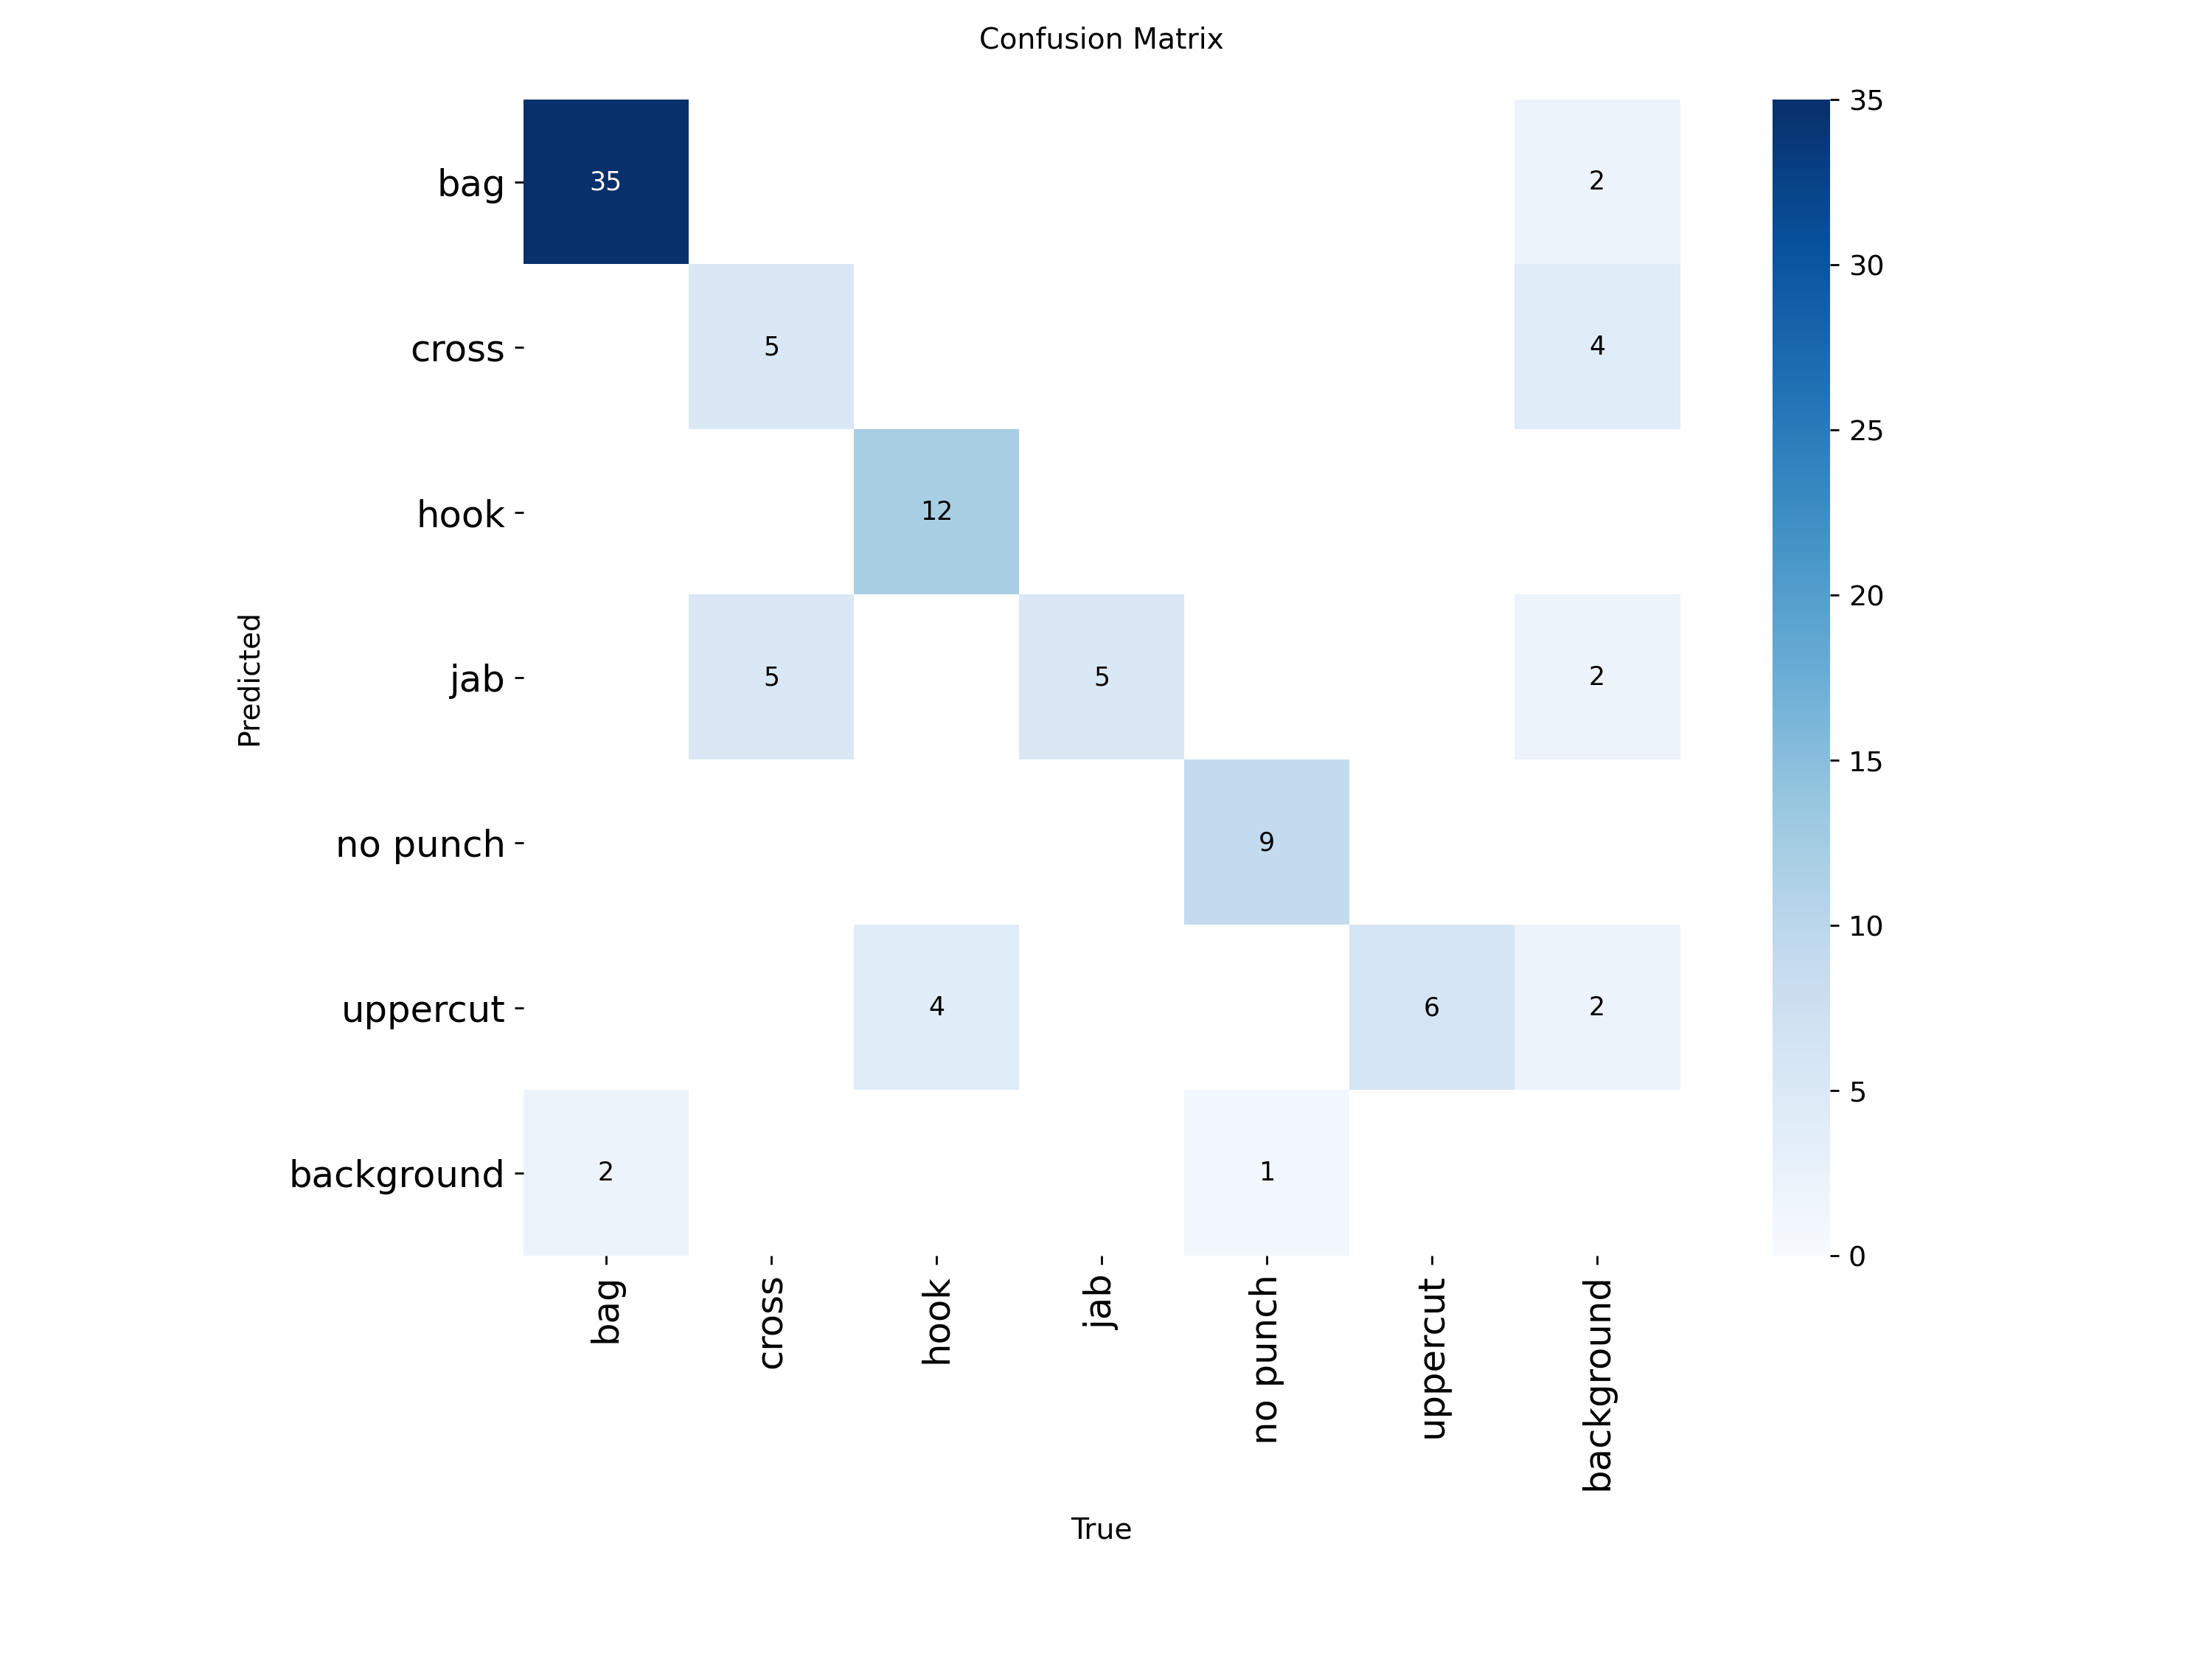

In [14]:
# Confusion matrix: shows per-class prediction accuracy
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/yolo26-object-detection/train/confusion_matrix.png', width=600)

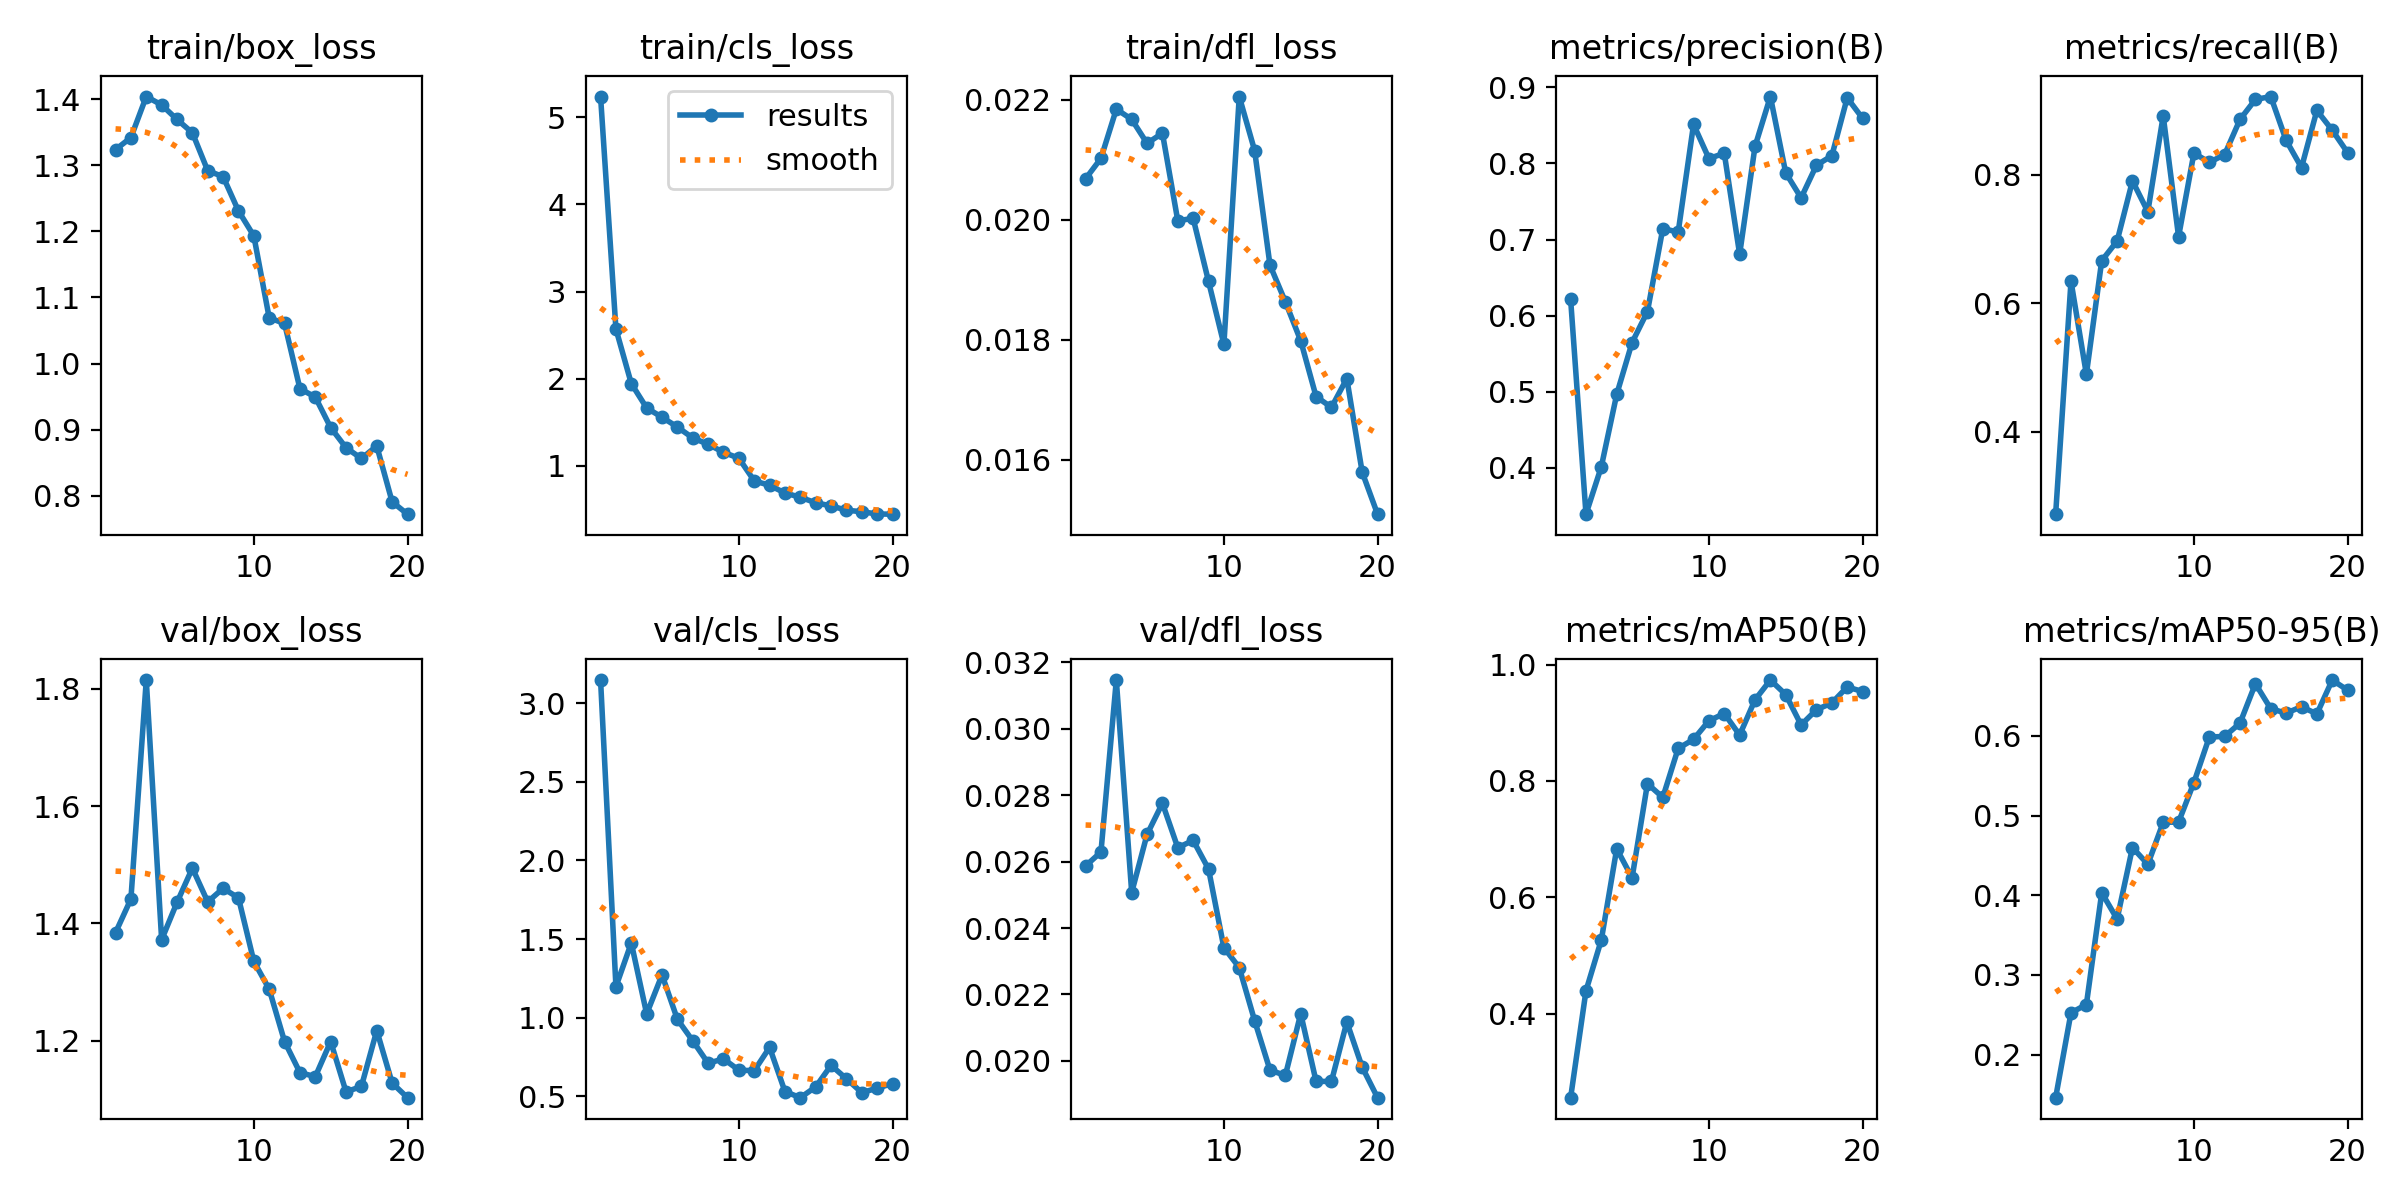

In [15]:
# Training curves: loss and metrics over epochs
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/yolo26-object-detection/train/results.png', width=600)

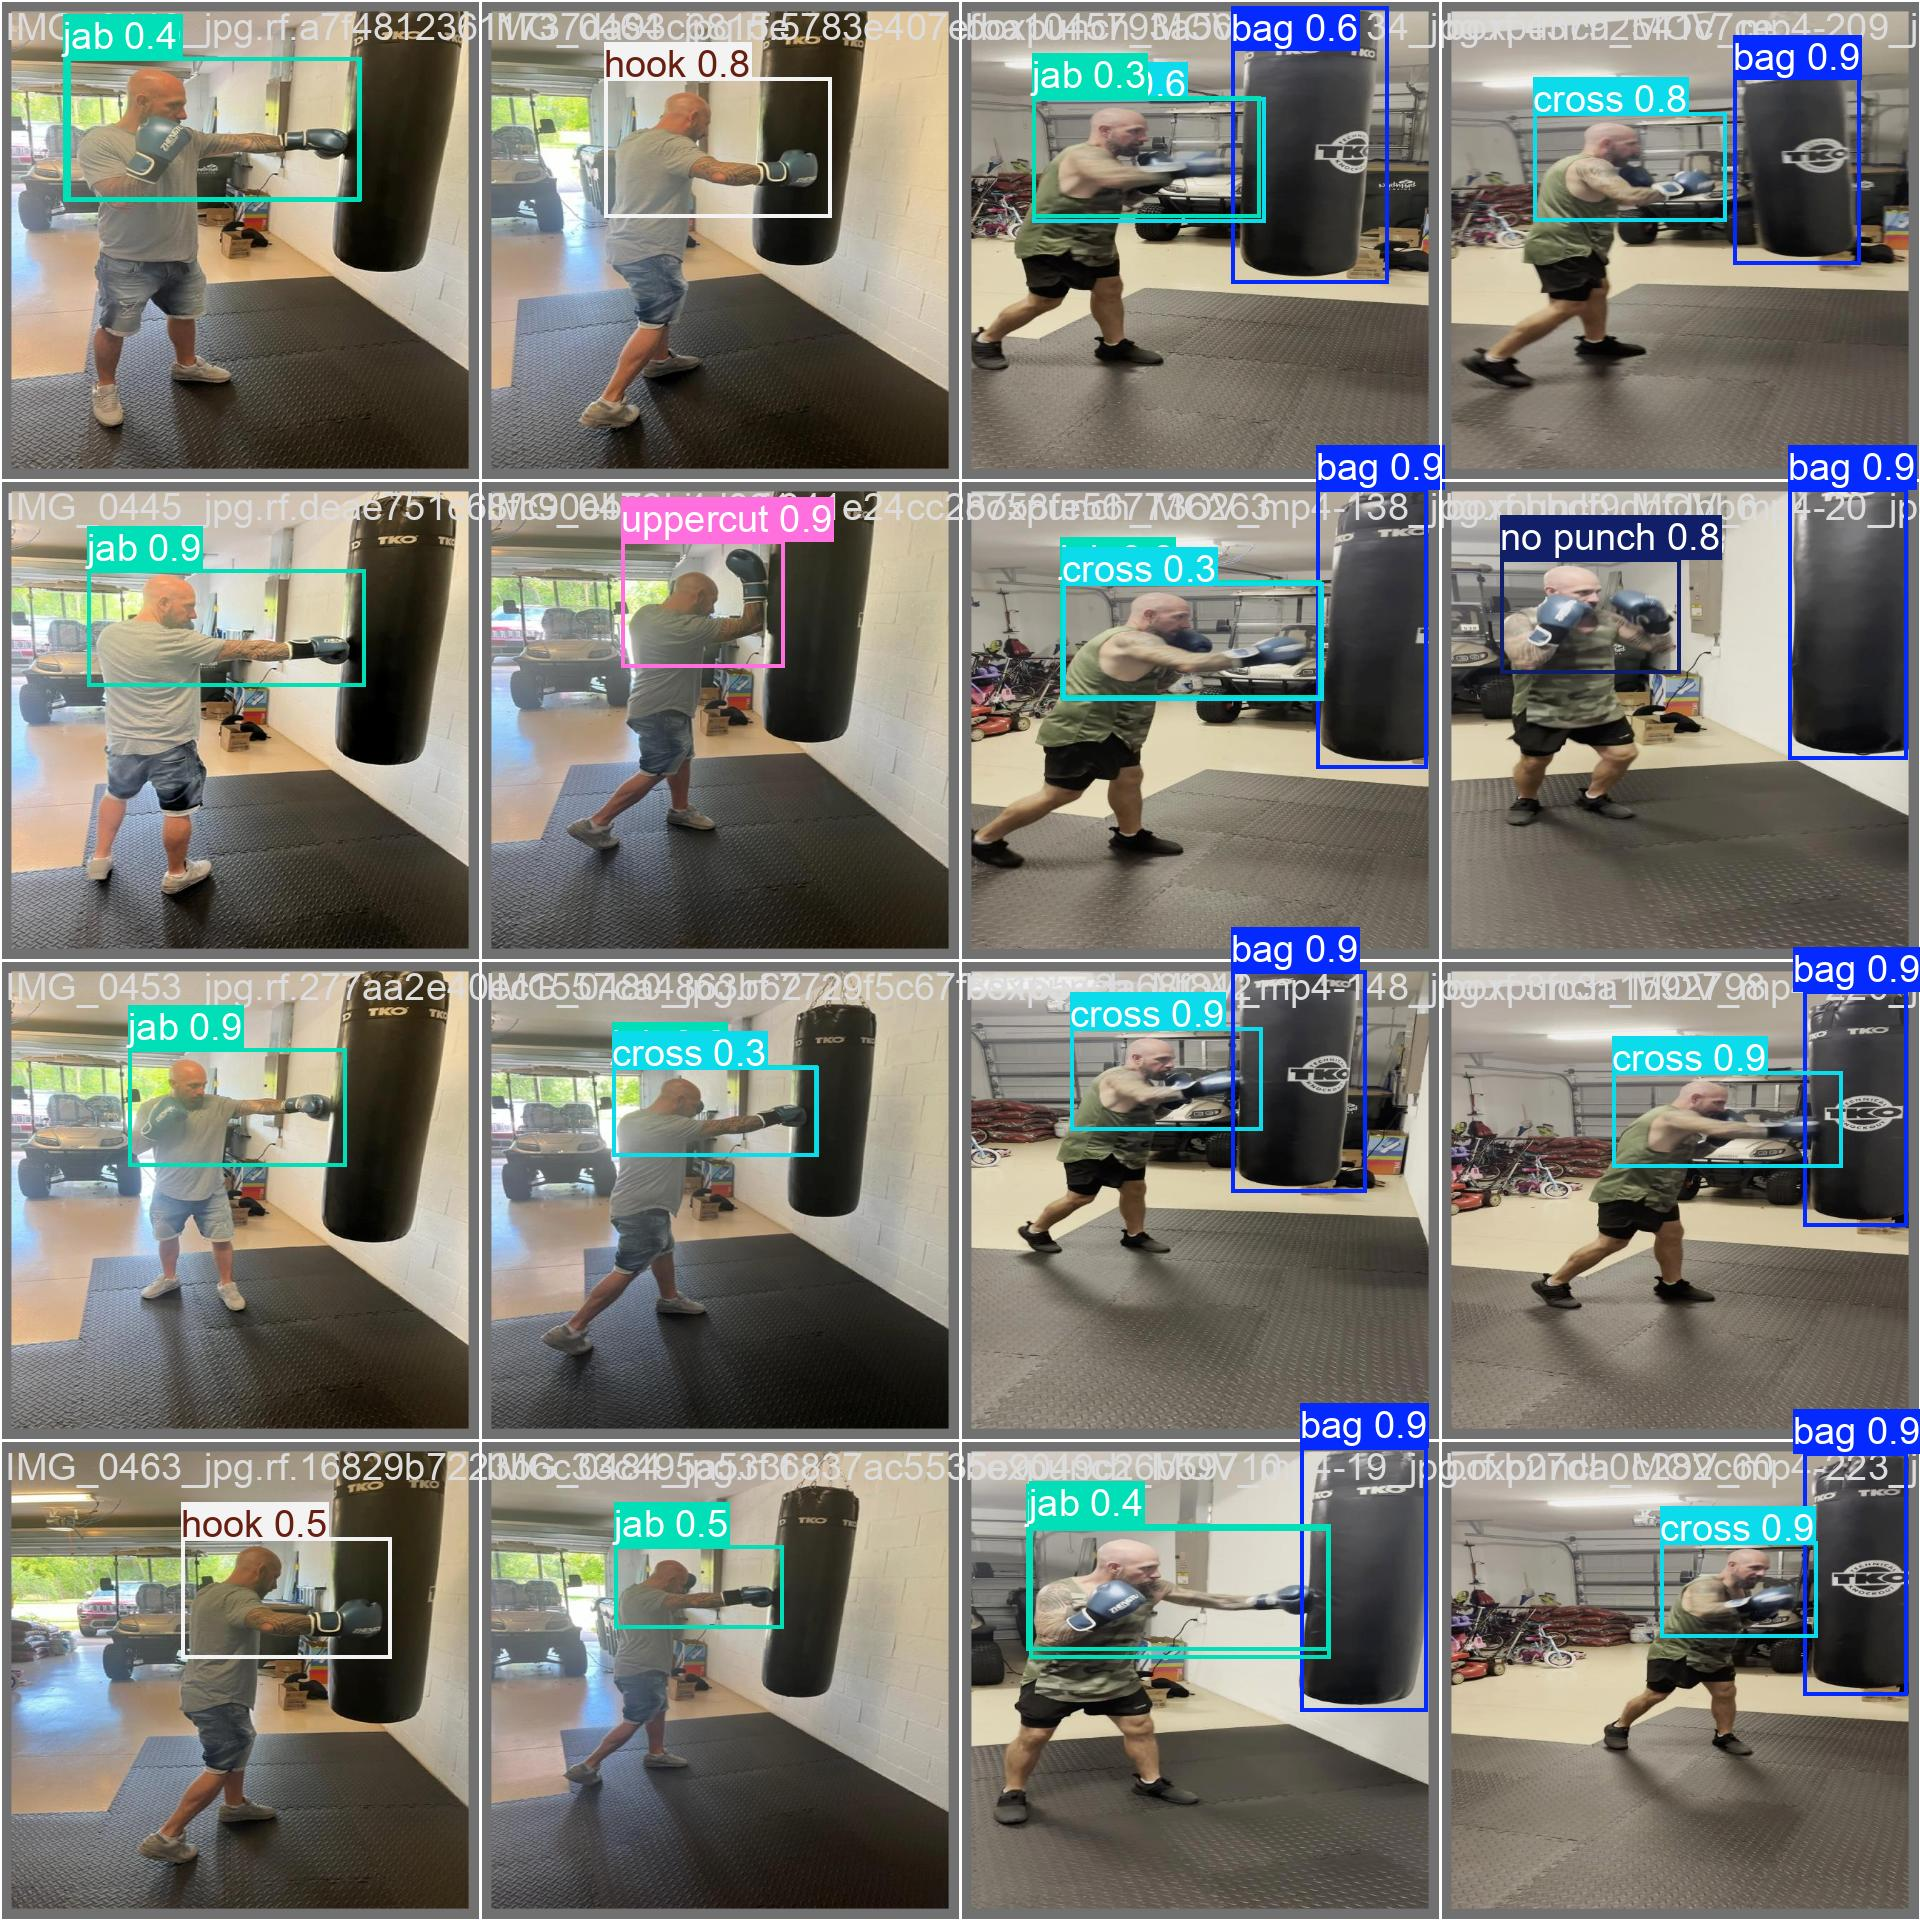

In [16]:
# Sample validation predictions from the final epoch
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/yolo26-object-detection/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

Run the Ultralytics validation mode on the best checkpoint to compute per-class precision, recall, mAP@50, and mAP@50-95 on the validation split.

In [17]:
from ultralytics import YOLO

# Load the fine-tuned model
model = YOLO(f'{HOME}/runs/detect/yolo26-object-detection/train/weights/best.pt')

# Evaluate the best checkpoint on the validation set
model.val(
    data=f'{dataset.location}/data.yaml',
    project='yolo26-object-detection'
)

Ultralytics 8.4.14 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (NVIDIA L4, 22813MiB)
YOLO26m summary (fused): 132 layers, 20,354,078 parameters, 0 gradients, 67.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1401.5±388.2 MB/s, size: 47.3 KB)
val: Scanning /teamspace/studios/this_studio/datasets/Boxpunch-Detector--19/valid/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 47/47 9.0Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.9it/s 1.6s1.0s
                   all         47         84      0.884      0.869      0.961       0.67
                   bag         37         37      0.972      0.943      0.955      0.769
                 cross         10         10          1      0.723      0.986      0.603
                  hook         16         16          1      0.694       0.94      0.583
                   jab          5          5      0.656          1      0.898      0.664
 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x75311c1609e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

## Inference with fine-tuned model

Run the fine-tuned model on the held-out test set. Then visualize a random grid of annotated predictions.

Load the fine-tuned model, run inference on test images, and visualize a 3x3 grid of annotated predictions using Supervision and Matplotlib.

In [18]:
from ultralytics import YOLO

# Load the fine-tuned model
model = YOLO(f'{HOME}/runs/detect/yolo26-object-detection/train/weights/best.pt')

In [19]:
import supervision as sv

# Load the test split as a Supervision DetectionDataset for easy iteration
ds_test = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [20]:
import supervision as sv
from PIL import Image

def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
    """Annotate an image with detections."""
    color = sv.ColorPalette.from_hex([
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00",
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    ])

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    # Create annotators
    box_annotator = sv.BoxAnnotator(color=color)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        smart_position=True
    )

    # Annotate and return
    out = image.copy()
    out = box_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections)
    out.thumbnail((1000, 1000))
    return out

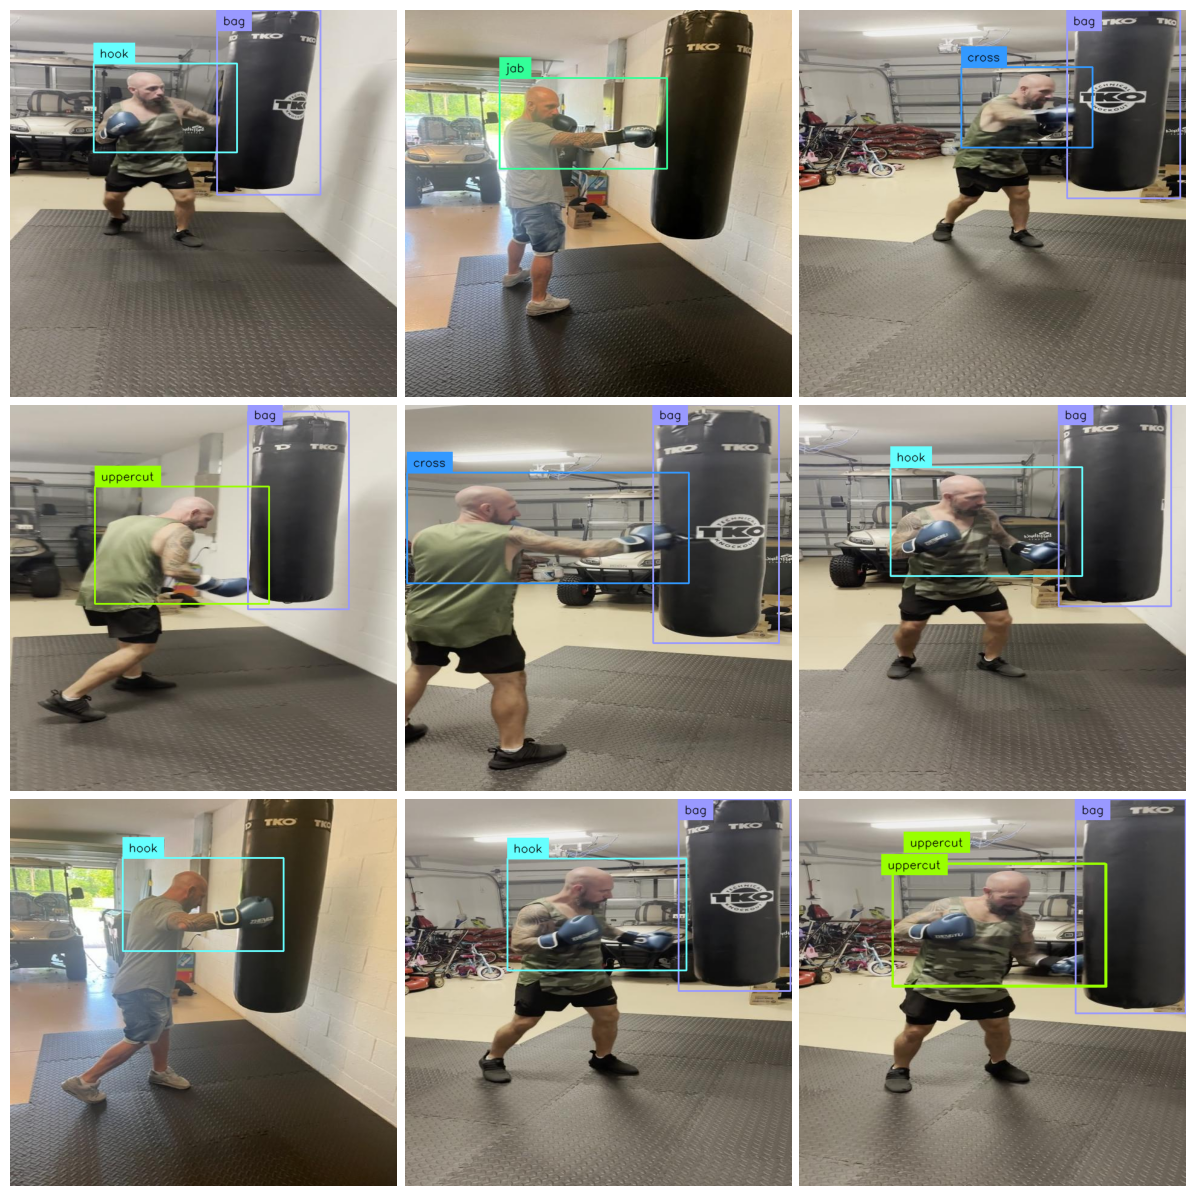

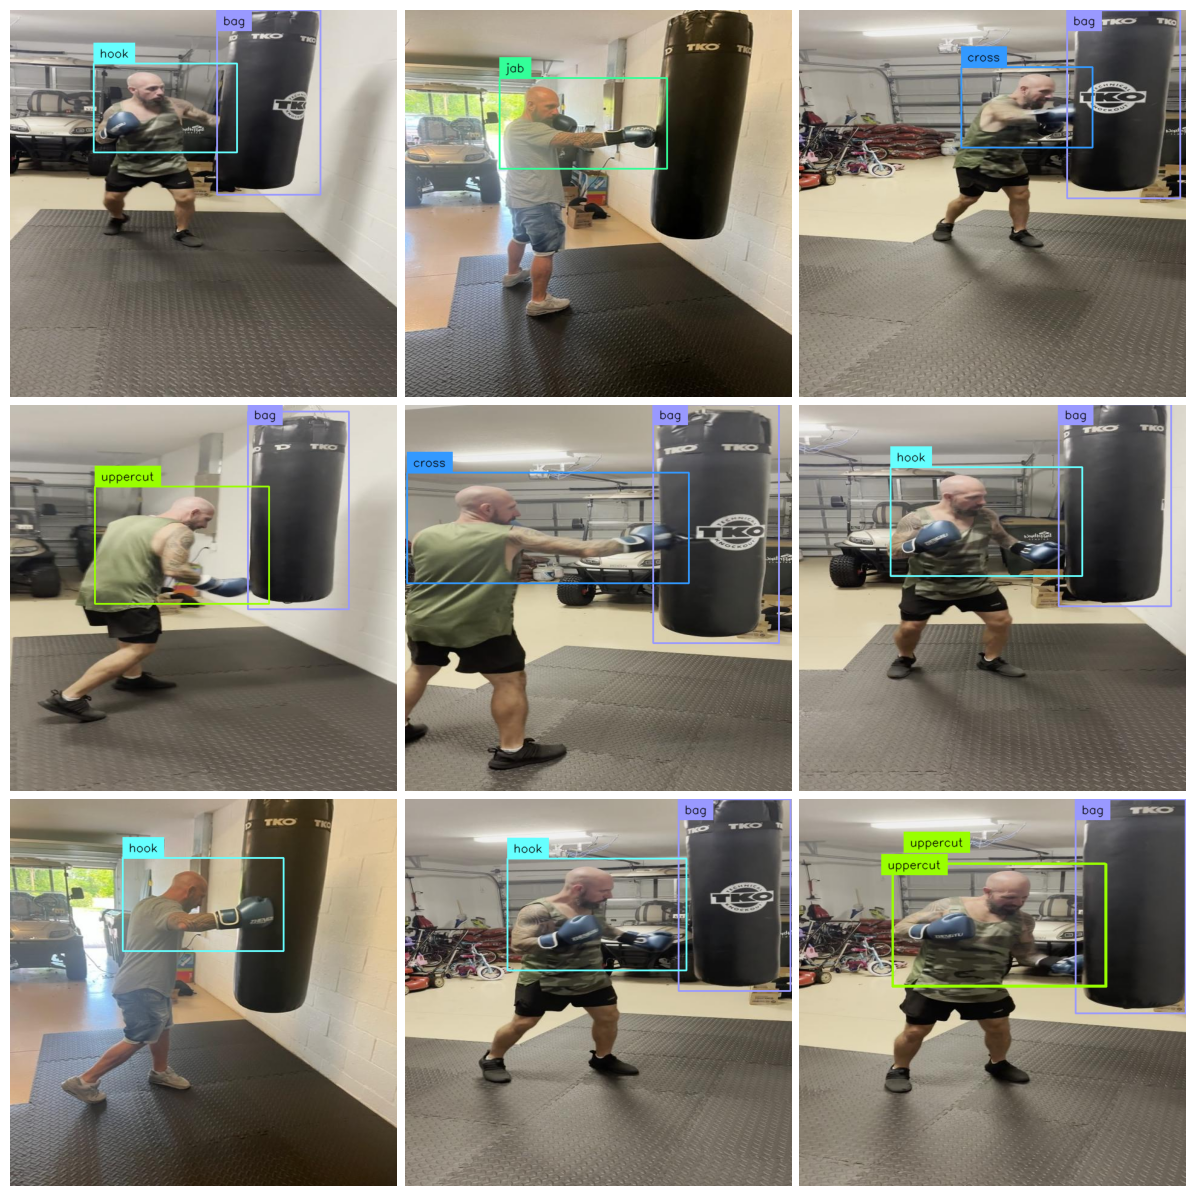

In [ ]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

N = 9
L = len(ds_test)

# Run inference on N randomly sampled test images and collect annotated results
annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    result = model.predict(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    annotated_image = annotate(image, detections)
    annotated_images.append(annotated_image)

# Display annotated images in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)

fig

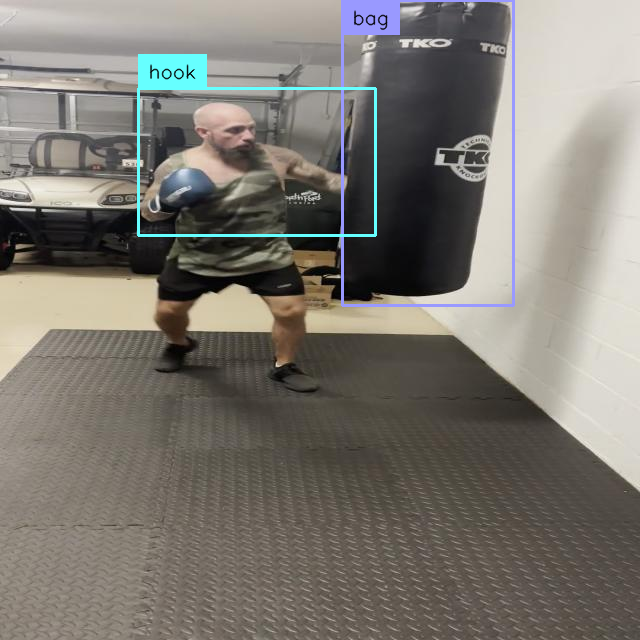

In [ ]:
# Close-up view of a single annotated prediction
annotated_images[0]

## Key Features

- **Experiment tracking with Comet ML** --- Training metrics, hyperparameters, and artifacts are logged automatically for reproducibility and comparison across runs.
- **End-to-end workflow** --- The notebook covers the full cycle: pre-trained inference, dataset download, fine-tuning, validation, and test-set evaluation in a single, reproducible pipeline.

## Conclusion

In this notebook we demonstrated how to fine-tune YOLO26m on a custom boxing-punch detection dataset. Starting from a COCO-pretrained checkpoint, the model was trained for 20 epochs on a Roboflow-hosted dataset and evaluated on a held-out validation split. The fine-tuned model successfully learned to localize punches in unseen test images, as shown in the annotated prediction grid.

To extend this workflow you can:

- **Try other model sizes** --- YOLO26 is available in nano, small, medium, large, and extra-large variants (`yolo26n`, `yolo26s`, `yolo26m`, `yolo26l`, `yolo26x`) to trade off speed and accuracy.
- **Deploy the model** --- Export the best checkpoint to ONNX, TensorRT, or CoreML for production inference using `model.export()`.